In [14]:
import random
import osmnx as ox
import networkx as nx
import numpy as np
import pickle
import pandas as pd
import json

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

In [15]:
# TODO delete this
FIG_SIZE=(16, 16)
TRAFFIC_DATA_PATH = "stockholm-basomrade-2020-1-All-HourlyAggregate.csv"

In [16]:
# functions for quick retrieval

def dump_file(filename, object_to_dump):
    file_opened = open(filename, "wb")
    pickle.dump(object_to_dump, file_opened)
    file_opened.close()

def load_object(filename):
    file_opened = open(filename, 'rb') 
    object = pickle.load(file_opened)
    file_opened.close()
    return object

In [17]:
G_stockholm = load_object("data/G_stockholm.pickle")

# Retrieving graph from place name
# G_stockholm = ox.graph_from_place('Stockholm, Sweden', network_type='walk')
# dump_file("data/G_stockholm.pickle", G_stockholm)


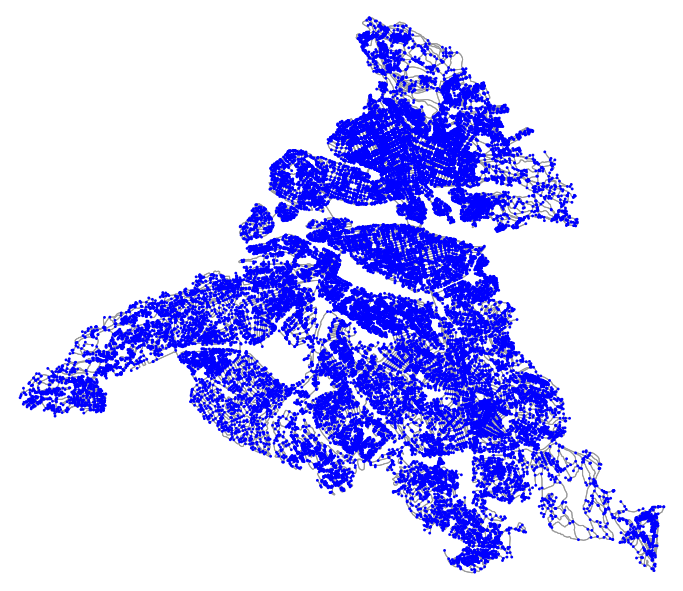

In [7]:
# Blue points represents osmnx nodes
ox.plot_graph(G_stockholm, figsize=(12, 12), node_size=8, bgcolor="w", node_color="b");

In [8]:
print('Number of nodes: {}'.format(G_stockholm.number_of_nodes()))
print('Number of edges: {}'.format(G_stockholm.number_of_edges()))

Number of nodes: 40199
Number of edges: 111500


In [9]:
# Projecting the graph to UTM
# G_proj = ox.project_graph(G_stockholm)
G_proj = load_object("data/G_stockholm.pickle")
nodes_proj = ox.graph_to_gdfs(G_proj, edges=False)
graph_area_m = nodes_proj.unary_union.convex_hull.area
print('G_stockholm cover area: {} square meters'.format(round(graph_area_m)))
print('G_stockholm cover area: {} square kilometers'.format(round(graph_area_m) / 1000000))    

G_stockholm cover area: 0 square meters
G_stockholm cover area: 0.0 square kilometers


In [10]:
ox.basic_stats(G_proj, area=graph_area_m, clean_int_tol=True)   

C:\Users\m84200118\Anaconda3\envs\ox\lib\site-packages\osmnx\simplification.py:424: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged = utils_graph.graph_to_gdfs(G, edges=False)["geometry"].buffer(tolerance).unary_union
C:\Users\m84200118\Anaconda3\envs\ox\lib\site-packages\osmnx\simplification.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return _merge_nodes_geometric(G, tolerance).centroid


{'n': 40199,
 'm': 111500,
 'k_avg': 5.547401676658623,
 'edge_length_total': 5450161.939999921,
 'edge_length_avg': 48.88037614349705,
 'streets_per_node_avg': 2.7757406900669173,
 'streets_per_node_counts': {0: 0,
  1: 8225,
  2: 2,
  3: 24730,
  4: 7061,
  5: 168,
  6: 12,
  7: 1},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.20460707977810394,
  2: 4.9752481405010074e-05,
  3: 0.6151894325729496,
  4: 0.17565113560038806,
  5: 0.004179208438020846,
  6: 0.00029851488843006047,
  7: 2.4876240702505037e-05},
 'intersection_count': 31974,
 'street_length_total': 2725080.9700000286,
 'street_segment_count': 55750,
 'street_length_avg': 48.88037614349827,
 'circuity_avg': 1.0728374436205839,
 'self_loop_proportion': 0.0025829596412556056,
 'clean_intersection_count': 1,
 'node_density_km': 1414147896566.7598,
 'intersection_density_km': 1124803225075.887,
 'edge_density_km': 191729521714448.12,
 'street_density_km': 95864760857226.45,
 'clean_intersection_density_km': 35178683.46393

In [11]:
# loading a map for cars and roads:
G_sto_drive = load_object("data/G_stockholm.pickle")
# ox.graph_from_place('Stockholm, Sweden', network_type='drive')


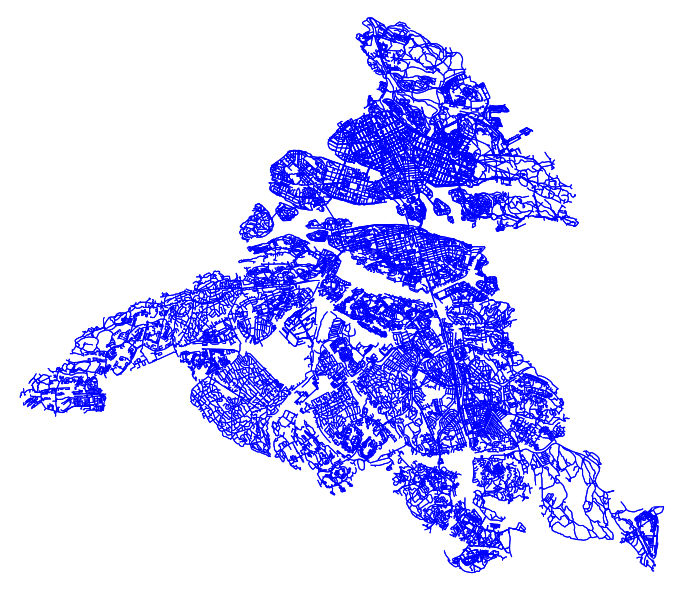

In [12]:
# Red color represents one-way roads and blue represents two-way roads
ec = ['r' if data['oneway'] else 'b' for u, v, key, data in G_sto_drive.edges(keys=True, data=True)]
ox.plot_graph(G_sto_drive, edge_color=ec, figsize=(12, 12), node_size=0, bgcolor="w");

### Task 3, generating 10 random points:

In [13]:
n_customers = 10
random.seed(1)

node_list = [i for i in G_sto_drive.nodes]

nodes_delivery = [random.choice(node_list) for _ in range(n_customers)]

node_center = ox.get_nearest_node(G_sto_drive, (28.542111, -81.37903))
print(nodes_delivery, node_center)

[492804203, 7514399538, 255856144, 1428997226, 446219969, 5665121739, 4263469872, 4995171085, 2298668212, 1243487825] 839031695


C:\Users\m84200118\Anaconda3\envs\ox\lib\site-packages\osmnx\distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)


### Task 4, calculating lenths matrix between points

In [18]:
def path_weight(G, nodes, weight):
    w = 0
    for ind,nd in enumerate(nodes[1:]):
        prev = nodes[ind]
        w += G[prev][nd][0][weight]
    return w

In [19]:
all_nodes = [node_center] + nodes_delivery

# distance matrix between each pair of nodes
length_matrix = np.zeros((len(all_nodes), len(all_nodes)),dtype=np.double)
# Finding the route between these nodes 
shortest_routes_map = {}

# map of coordinates of each point:
coordinates = {}

for from_idx in range(len(all_nodes)):
    coordinates[from_idx] = G_sto_drive.nodes[all_nodes[from_idx]]

    shortest_routes_map[from_idx] = {}
    for to_idx in range(len(all_nodes)):
        if from_idx == to_idx:
            length_matrix[from_idx][to_idx] = 10**6-1
        else:
            route = nx.shortest_path(G_sto_drive, all_nodes[from_idx], all_nodes[to_idx], weight='length')
            length_matrix[from_idx][to_idx] = path_weight(G_sto_drive, route, "length")
            shortest_routes_map[from_idx][to_idx] = route.copy()

pd.DataFrame(length_matrix)

,0,1,2,3,4,5,6,7,8,9,10
0,999999.000,19191.987,17963.793,19702.431,15746.280,19166.820,16758.931,8876.137,16563.877,9756.797,18168.999
1,19187.228,999999.000,1606.691,7276.396,4278.325,15566.592,3441.274,10590.708,7849.276,11274.711,12810.427
2,17959.034,1606.691,999999.000,5669.705,2925.754,14108.443,1836.101,9362.514,6443.055,10046.517,11352.278
3,19702.431,7283.546,5676.855,999999.000,4748.576,15583.769,3997.026,11105.911,7918.381,11789.914,12827.604
4,15746.280,4278.325,2925.754,4748.576,999999.000,11679.546,1558.125,7149.760,3962.230,7833.763,8923.381
5,19166.820,15566.592,14108.443,15583.769,11679.546,999999.000,12640.269,10565.398,9654.513,10146.987,3068.264
6,16758.931,3441.274,1836.101,3997.026,1558.125,12640.269,999999.000,8162.411,4974.881,8846.414,9884.104
7,8876.137,10595.467,9367.273,11105.911,7149.760,10565.398,8162.411,999999.000,7967.357,1509.107,9567.577
8,16563.877,7849.276,6443.055,7918.381,3962.230,9654.513,4974.881,7967.357,999999.000,8651.360,6898.348
9,9756.797,11279.470,10051.276,11789.914,7833.763,10146.987,8846.414,1509.107,8651.360,999999.000,9149.166


### Travelling Salesman Problem

I would use The Miller-Tucker-Zemlin (MTZ) formulation of TSP:

In [20]:
import pyomo.environ as pyEnv

cost_matrix = length_matrix

In [21]:
model = pyEnv.ConcreteModel()

#Indexes for the cities
model.M = pyEnv.RangeSet(10)                
model.N = pyEnv.RangeSet(10)

#Index for the dummy variable u
model.U = pyEnv.RangeSet(2,10)

In [22]:
# xij
model.x=pyEnv.Var(model.N,model.M, within=pyEnv.Binary)
# ui
model.u=pyEnv.Var(model.N, within=pyEnv.NonNegativeIntegers,bounds=(0, 10-1))

In [23]:
model.c = pyEnv.Param(model.N, model.M,initialize=lambda model, i, j: cost_matrix[i-1][j-1])

In [24]:
def obj_func(model):
    return sum(model.x[i,j] * model.c[i,j] for i in model.N for j in model.M)

model.objective = pyEnv.Objective(rule=obj_func,sense=pyEnv.minimize)

In [25]:
def rule_const1(model,M):
    return sum(model.x[i,M] for i in model.N if i!=M ) == 1

model.const1 = pyEnv.Constraint(model.M,rule=rule_const1)

In [26]:
def rule_const2(model,N):
    return sum(model.x[N,j] for j in model.M if j!=N) == 1

model.rest2 = pyEnv.Constraint(model.N,rule=rule_const2)

In [27]:
def rule_const3(model,i,j):
    if i!=j: 
        return model.u[i] - model.u[j] + model.x[i,j] * 10 <= 10-1
    else:
        return model.u[i] - model.u[i] == 0 
    
model.rest3 = pyEnv.Constraint(model.U,model.N,rule=rule_const3)

In [28]:
model.pprint()

3 Set Declarations
    c_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain : Size : Members
        None :     2 :    N*M :  100 : {(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (6, 8), (6, 9), (6, 10), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7), (7, 8), (7, 9), (7, 10), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8), (8, 9), (8, 10), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8), (9, 9), (9, 10), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (10, 7), (10, 8), (10, 9), (10, 10)}
    rest3_index : Size=1, I

In [31]:
#Solves
solver = pyEnv.SolverFactory('cplex')
result = solver.solve(model,tee = False)
result = solver.solve(model)

In [32]:
# also doing usual full permutation TSP algorithm to make sure that my solution is optimal:
from python_tsp.exact import solve_tsp_dynamic_programming

permutation, distance = solve_tsp_dynamic_programming(length_matrix)
permutation, distance

([0, 9, 5, 10, 8, 4, 3, 6, 2, 1, 7], 65487.86499999999)

## Visualization the solved problem:

In [33]:
shortest_routes_map[permutation[0]][permutation[1]]

# creating the path from the list of nodes:
route_list = [shortest_routes_map[permutation[0]][permutation[1]].copy()]
for i in range(1, len(permutation) - 1):
    next_path = shortest_routes_map[permutation[i]][permutation[i + 1]].copy()
    route_list.append(next_path)
route_list.append(shortest_routes_map[permutation[-1]][permutation[0]])



In [43]:
x = shortest_routes_map[0][1]
total_route = nx.shortest_path(G_sto_drive, x[0], x[-1], weight='length')

"number of streets in path:", len(x)

('number of streets in path:', 294)

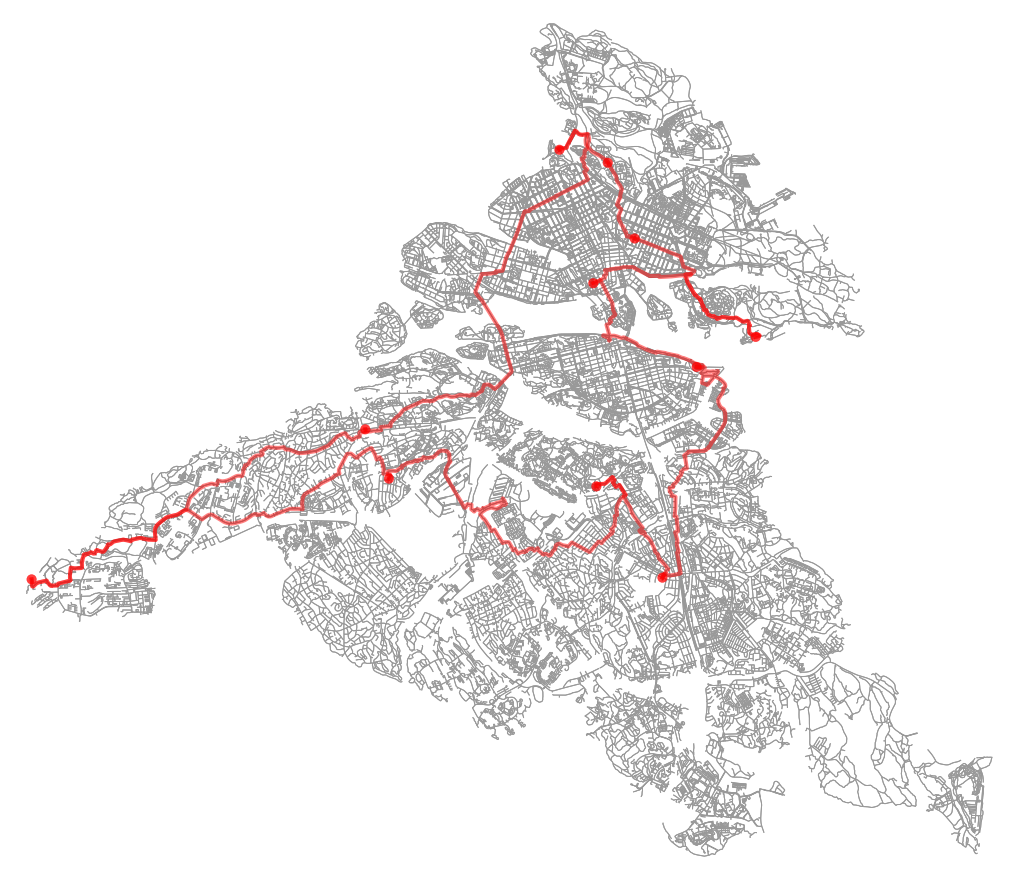

In [35]:
fig, ax = ox.plot_graph_routes(G_sto_drive, route_list, figsize=(18, 18), node_size=0, bgcolor="w")

#### WOW! That actually works, and it is easy now to take any kind of objective function, and just minimize that using uber movement data, or anything else!

 ### Integrating Uber Movement data
 

Getting zone dictionary

In [36]:
from shapely.geometry import Point, Polygon

def get_zones(path):
    with open(path) as f:
        dct = json.load(f)

    zones = {}
    for feat in dct["features"]:
        name = feat["properties"]["MOVEMENT_ID"]
        zones[name] = Polygon(feat["geometry"]["coordinates"][0])
    return zones

zones = get_zones('stockholm_basomrade.json')
print(f"Number of zones in Stockholm: {len(zones)}")

Number of zones in Stockholm: 1239


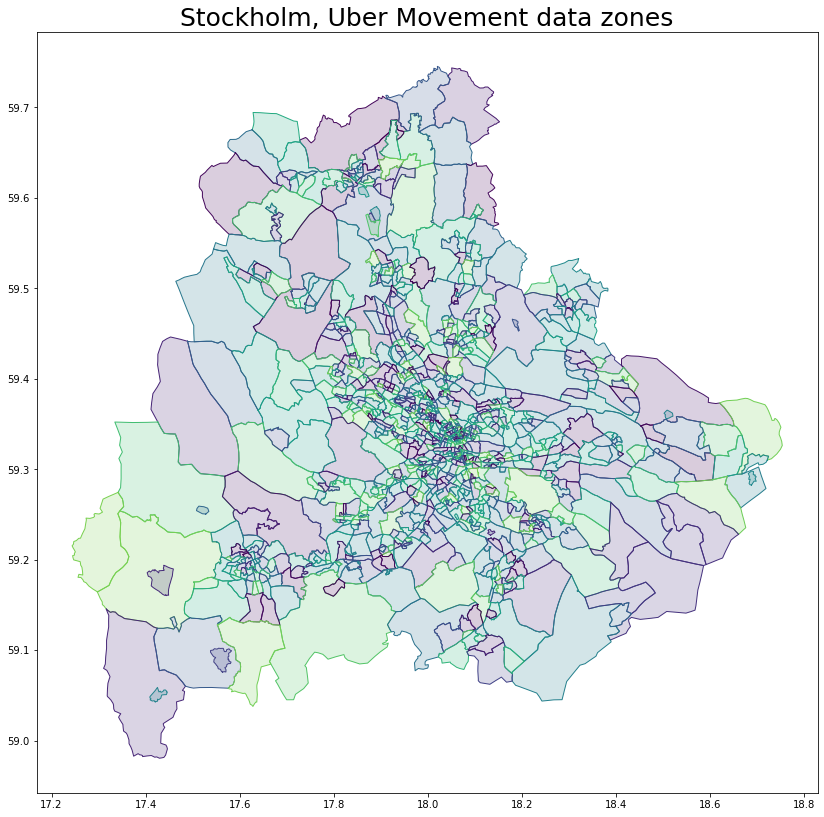

In [37]:
import matplotlib
import matplotlib.pyplot as plt


def generate_zone_colors(k=0.8):
    # generate random color for each zone
    zone_colors = {}
    cmap = matplotlib.cm.get_cmap('viridis')
    for z in zones.keys():
        zone_colors[z] = cmap(random.random() * k)
    return zone_colors
    
def plot_zones_borders(polygon_zones, zone_colors, order=1, linewidth=1, fill=False):
    for zone, poly in list(polygon_zones.items()):
        # print(list(poly.exterior.coords))
        coords = list(poly.exterior.coords)#poly["coordinates"][0]
        if len(coords) == 1:
            coords = coords[0]
        plt.plot(*zip(*coords), label=zone, c=zone_colors[zone], zorder=order, linewidth=linewidth)
        if fill:
            plt.fill(*zip(*coords), matplotlib.colors.to_hex(zone_colors[zone]) + "33")

zone_colors = generate_zone_colors()

plt.figure(figsize=(14, 14))
plot_zones_borders(zones, zone_colors, fill=True)
plt.title("Stockholm, Uber Movement data zones", fontsize=25)
plt.show()

Getting the zone for each point:

In [38]:
def find_zone(x, y, zones):
    point = Point(x, y)
    for zone_name in zones:
        if point.within(zones[zone_name]):
            return zone_name
    print("no zone", x, y)
    return None

# looking for an appropriate zones using linear search and then searching in all of the polygons
for point_idx in range(len(all_nodes)):
    x, y = coordinates[point_idx]['x'], coordinates[point_idx]['y']
    coordinates[point_idx]['zone'] = find_zone(x, y, zones)
    print(coordinates[point_idx])

zones_list = [int(coordinates[zone]['zone']) for zone in coordinates]


{'y': 59.2784044, 'x': 17.8699117, 'street_count': 1, 'zone': '850'}
{'y': 59.3534673, 'x': 18.0505665, 'street_count': 3, 'zone': '473'}
{'y': 59.3512012, 'x': 18.0671127, 'street_count': 3, 'zone': '474'}
{'y': 59.3207709, 'x': 18.1177506, 'street_count': 1, 'zone': '644'}
{'y': 59.3301471, 'x': 18.0621679, 'street_count': 3, 'zone': '641'}
{'y': 59.2946525, 'x': 18.0632195, 'street_count': 3, 'zone': '780'}
{'y': 59.3379668, 'x': 18.0763349, 'street_count': 3, 'zone': '590'}
{'y': 59.304622, 'x': 17.9841302, 'street_count': 1, 'zone': '779'}
{'y': 59.3155246, 'x': 18.0975451, 'street_count': 3, 'zone': '691'}
{'y': 59.296001, 'x': 17.9922157, 'street_count': 3, 'zone': '808'}
{'y': 59.2787046, 'x': 18.0858237, 'street_count': 3, 'zone': '852'}


In [39]:
def get_zone_distance_matrix_by_hour():
    df = pd.read_csv("data/stockholm-basomrade-2020-1-All-HourlyAggregate.csv")

    zone_distance_matrix = {}
    for i in df.iterrows():
        source = i[1][0]
        dst = i[1][1]
        hod = i[1][2]
        mean_travel_time = i[1][3]                         
        if source not in zone_distance_matrix:
            zone_distance_matrix[source] = {}
        if dst not in zone_distance_matrix[source]:
            zone_distance_matrix[source][dst] = {}
        # if hod not in zone_distance_matrix[source][dst]:
        #     zone_distance_matrix[source][dst][hod] = {}
        zone_distance_matrix[source][dst][hod] = mean_travel_time
    return zone_distance_matrix

zone_distance_matrix = load_object("data/zone_distance_matrix.pickle")
# zone_distance_matrix = get_zone_distance_matrix_by_hour()


Creating an average travel time matrix just to show that there is insufficient data to work with:

In [40]:
zones_matrix = np.zeros((len(zones_list), len(zones_list)))

for i in range(len(zones_list)):
    for j in range(len(zones_list)):
        if i == j:
            zones_matrix[i][j] = 0
        else:
            zones_matrix[i][j] = np.nan
            if zones_list[i] in zone_distance_matrix:
                if zones_list[j] in zone_distance_matrix[zones_list[i]]:
                    hods = zone_distance_matrix[zones_list[i]][zones_list[j]]
                    hods_list = [hods[i] for i in hods]
                    time_avg = sum(hods_list) / len(hods_list)
                    zones_matrix[i][j] = time_avg

In [41]:
pd.DataFrame(zones_matrix)

,0,1,2,3,4,5,6,7,8,9,10
0,0.000,NaN,NaN,NaN,NaN,925.917273,NaN,NaN,NaN,NaN,NaN
1,NaN,0.000000,199.175417,NaN,560.847500,772.717083,401.413333,680.558333,865.327083,710.130000,892.627917
2,NaN,186.936667,0.000000,NaN,612.383750,740.084583,475.473889,NaN,824.952917,NaN,876.894583
3,NaN,NaN,711.880000,0.0,581.570000,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,588.899167,651.082500,NaN,0.000000,299.737917,474.259444,NaN,369.982083,605.438333,421.894583
5,707.486,715.678750,758.489167,NaN,395.922083,0.000000,572.977727,774.337500,715.110833,408.081818,195.862083
6,NaN,482.763750,475.857083,NaN,477.197500,692.129167,0.000000,NaN,823.222105,NaN,867.745556
7,NaN,834.617500,NaN,NaN,NaN,765.093636,NaN,0.000000,NaN,NaN,750.400000
8,NaN,804.952273,855.609474,NaN,586.275417,708.369583,792.311875,NaN,0.000000,NaN,748.060870
9,NaN,804.685000,NaN,NaN,NaN,552.921250,NaN,NaN,NaN,0.000000,604.178125


In [42]:
num_zones = len(zone_distance_matrix)
print(f"Total number of zones: {num_zones}")

mean_zone_degree = sum([len(i) / num_zones for i in zone_distance_matrix.values()])
print(f"Average zone's neighbours quantity: {mean_zone_degree}")
print(f"Edge completness: {round(100 * mean_zone_degree / num_zones, 2)}%")

Total number of zones: 1123
Average zone's neighbours quantity: 201.55209260908342
Edge completness: 17.95%


### We can see that only 18% of all edges are present, and a lot of them are needed for meaningful results in this assignment, so it would be too inaccurate and hard to interpolate them using bfs. Also it would be quite complex to do so, as we probably want to find out the quickest route. That is why I don't include uber movement data in this assighnment, although it is easy to make it work with my linear programming model.